# Business analysis (online tickets store)

The aim of this project is to help optimize marketing expenses based on data collected from Yandex.Afisha. 

In course of this project we are calculating major business metrics for a website: 
- user activity (DAU, WAU, MAU), visits per day, visits per user, session length, retention rate, conversion rate)
- unit economics (number of orders, average purchase rate, LTV)
- marketing expenses (CAC, ROMI)

## Download of the data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from datetime import datetime
import seaborn as sns

### Datasets download

In [2]:
try:
    visits=pd.read_csv('/datasets/visits_log_us.csv') 
    orders=pd.read_csv('/datasets/orders_log_us.csv')
    costs=pd.read_csv('/datasets/costs_us.csv')
except:
    visits=pd.read_csv('visits_log_us.csv') 
    orders=pd.read_csv('orders_log_us.csv')
    costs=pd.read_csv('costs_us.csv')

In [3]:
visits.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [4]:
#change of columns headers
visits.columns = visits.columns.str.replace(" ", "_").str.lower()

In [5]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   device     359400 non-null  object
 1   end_ts     359400 non-null  object
 2   source_id  359400 non-null  int64 
 3   start_ts   359400 non-null  object
 4   uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [6]:
orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [7]:
#change of columns headers
orders.columns=orders.columns.str.replace(" ", "_").str.lower()

In [8]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   buy_ts   50415 non-null  object 
 1   revenue  50415 non-null  float64
 2   uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [9]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [10]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


### Datatypes change

We are going to use timestamps and dates in our further analysis, so they need to be converted into datetime format.

In [11]:
visits['end_ts']=pd.to_datetime(visits['end_ts'], format="%Y-%m-%d %H:%M")

In [12]:
visits['start_ts']=pd.to_datetime(visits['start_ts'], format="%Y-%m-%d %H:%M")

In [13]:
orders['buy_ts']=pd.to_datetime(orders['buy_ts'], format="%Y-%m-%d %H:%M")

In [14]:
costs['dt']=pd.to_datetime(costs['dt'], format="%Y-%m-%d %H:%M")

## Reports and metrics

### Product

In [15]:
visits['year']  = visits['start_ts'].dt.isocalendar().year
visits['month']  = visits['start_ts'].dt.month
visits['week']  = visits['start_ts'].astype('datetime64[W]')
visits['date']  = visits['start_ts'].dt.date

In [16]:
visits.head()

,device,end_ts,source_id,start_ts,uid,year,month,week,date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,2017-12-14,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,2018-02-15,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,2017-06-29,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,2018-05-17,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,2017-12-21,2017-12-27


#### Visits: source / device

In [17]:
total_visits=visits['uid'].count()
print(F'\033[1mTotal number of visits: {total_visits}\033[1m')

Total number of visits: 359400


In [18]:
visits_per_source=visits.groupby('source_id')['uid'].count().reset_index().sort_values(by='uid', ascending=False)
visits_per_source['%']=round(visits_per_source['uid']/total_visits*100,2)
visits_per_source

,source_id,uid,%
3,4,101794,28.32
2,3,85610,23.82
4,5,66905,18.62
1,2,47626,13.25
0,1,34121,9.49
7,9,13277,3.69
8,10,10025,2.79
6,7,36,0.01
5,6,6,0.00


In [19]:
visits_per_device=visits.groupby('device')['uid'].count().reset_index().sort_values(by='uid', ascending=False)
visits_per_device['%']=round(visits_per_device['uid']/total_visits*100,2)
visits_per_device

,device,uid,%
0,desktop,262567,73.06
1,touch,96833,26.94


In [20]:
visits_per_source_device=visits.groupby(['source_id','device'])['uid'].count().reset_index()
visits_per_source_device_piv=visits_per_source_device.pivot_table(index='source_id', 
                                                                  columns='device', values='uid').reset_index()
visits_per_source_device_piv

device,source_id,desktop,touch
0,1,25901,8220
1,2,35661,11965
2,3,65777,19833
3,4,67640,34154
4,5,50069,16836
5,6,5,1
6,7,28,8
7,9,10119,3158
8,10,7367,2658


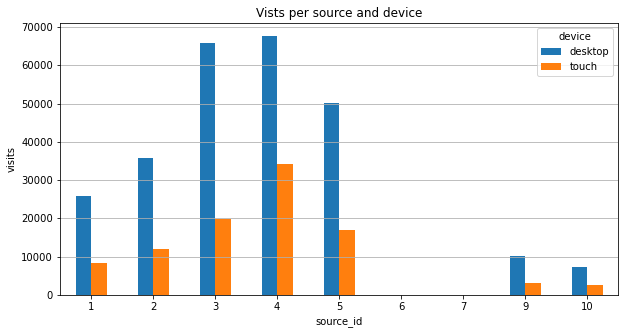

In [21]:
fig, axs = plt.subplots(figsize=(10, 5))
visits_per_source_device_piv.plot(rot=0, x='source_id',
        kind='bar',
        stacked=False,
        title='Vists per source and device', ax=axs, ylabel='visits')
plt.grid(axis='y')
plt.show()

Most part of visits (73%) are made via desktop devices. Major sources for visits were 3 and 4, making together about half of all traffic.

#### Visitors: source / device

In [22]:
total_visitors=visits['uid'].nunique()
print(F'\033[1mTotal number of visitors: {total_visitors}\033[0m')

Total number of visitors: 228169


In [23]:
first_visit_source=visits.sort_values('start_ts').groupby('uid').first()[['source_id','device']].reset_index()
first_visit_source.head()

,uid,source_id,device
0,11863502262781,3,touch
1,49537067089222,2,touch
2,297729379853735,3,desktop
3,313578113262317,2,desktop
4,325320750514679,5,desktop


In [24]:
visitors_per_source=(first_visit_source.groupby(
                    'source_id')['uid'].nunique().reset_index().sort_values(by='uid', ascending=False))
visitors_per_source['%']=round(visitors_per_source['uid']/total_visitors*100,2)
visitors_per_source

,source_id,uid,%
3,4,72346,31.71
2,3,66116,28.98
4,5,49237,21.58
1,2,17616,7.72
0,1,9469,4.15
8,10,6903,3.03
7,9,6448,2.83
6,7,32,0.01
5,6,2,0.00


In [25]:
visitors_per_device=first_visit_source.groupby('device')['uid'].nunique().reset_index().sort_values(by='uid', ascending=False)
visitors_per_device['%']=round(visitors_per_device['uid']/total_visitors*100,2)
visitors_per_device

,device,uid,%
0,desktop,160795,70.47
1,touch,67374,29.53


In [26]:
visitors_per_source_device=first_visit_source.groupby(['source_id','device'])['uid'].nunique().reset_index()
visitors_per_source_device_piv=visitors_per_source_device.pivot_table(index='source_id', 
                                                                      columns='device', values='uid').reset_index()
visitors_per_source_device_piv

device,source_id,desktop,touch
0,1,6347.0,3122.0
1,2,11771.0,5845.0
2,3,50190.0,15926.0
3,4,46965.0,25381.0
4,5,35822.0,13415.0
5,6,2.0,NaN
6,7,24.0,8.0
7,9,4828.0,1620.0
8,10,4846.0,2057.0


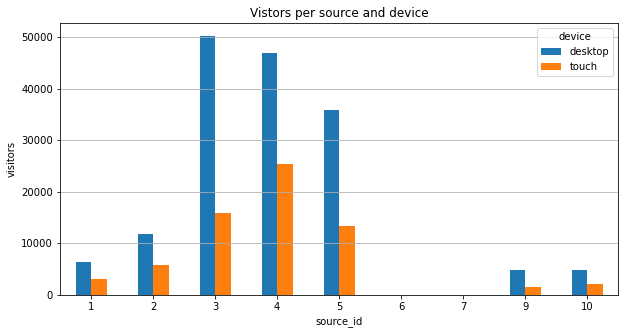

In [27]:
fig, axs = plt.subplots(figsize=(10, 5))
visitors_per_source_device_piv.plot(rot=0, x='source_id',
        kind='bar',
        stacked=False,
        title='Vistors per source and device', ax=axs, ylabel='visitors')
plt.grid(axis='y')
plt.show()

Unique visitors statistics has structure similar to visits data. However, looking at the plot, it could be noted, that the difference in visitor per source (50 thousands vs 10 thousands for sources 3 and 2 respectively) is greater than the difference in visit per source (35 thousand vs 35 thousand for sources 3 and 2 respectively). We can suggest that users from source 1 and 2 make more visits than users from sources 3 and 4.

#### DAU

DAU — the number of daily active (unique) users

In [28]:
dau = visits.groupby('date')['uid'].nunique().reset_index()
dau.head()

,date,uid
0,2017-06-01,605
1,2017-06-02,608
2,2017-06-03,445
3,2017-06-04,476
4,2017-06-05,820


In [29]:
dau_av=int(dau.mean(numeric_only=True))
print(F'\033[1mAverage DAU: {dau_av}\033[0m')

Average DAU: 907


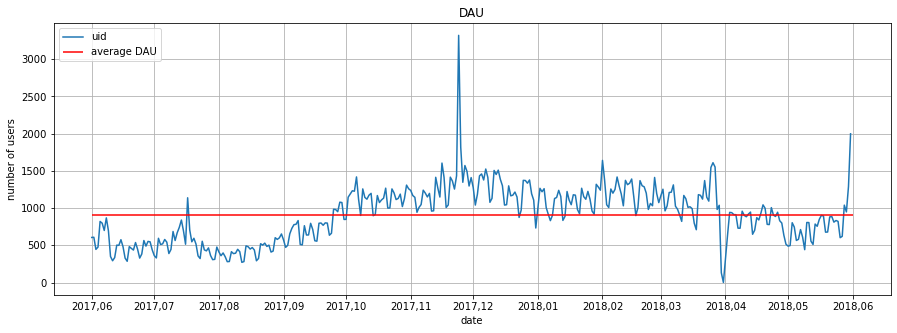

In [30]:
fig, axs = plt.subplots(figsize=(15, 5))
fig = dau.plot(kind='line', x="date", y="uid", title='DAU', x_compat=True, grid='True', ax=axs, ylabel='number of users')
dtFmt = mdates.DateFormatter('%Y,%m') # define the formatting
plt.gca().xaxis.set_major_formatter(dtFmt) # apply the format to the desired axis
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1)) # show every 12th tick on x axes
plt.hlines(dau_av, '2017-06-01', '2018-06-01', color='red', label= 'average DAU')
plt.legend(loc = 'upper left')
plt.show(close='All')

We have overall rising trend in user activity in September-December 2017 with a single peak on the last days of November (could be seasonal demand or advertising event), than relatively stable period up to end of March 2018 and drop to zero at one of the last days in March (maybe there were some technical issues in one particular day).

#### WAU

WAU — the number of weekly active users

In [31]:
wau = visits.groupby('week')['uid'].nunique().reset_index()
wau.head()

,week,uid
0,2017-06-01,4082
1,2017-06-08,3311
2,2017-06-15,2844
3,2017-06-22,3079
4,2017-06-29,3055


In [32]:
wau_av=int(wau['uid'].mean())
print(F'\033[1mAverage WAU: {wau_av}\033[0m')

Average WAU: 5724


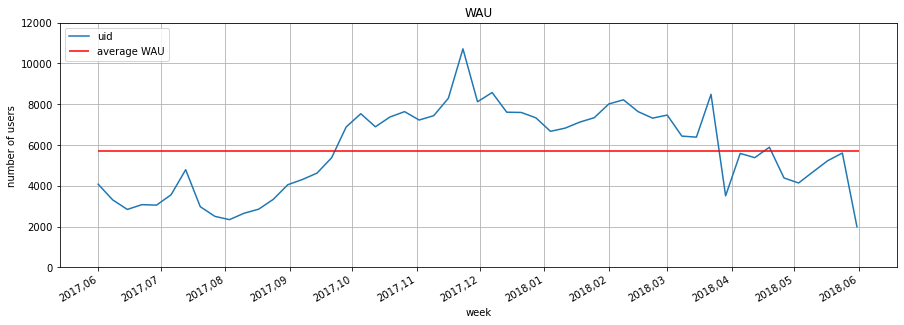

In [33]:
fig, axs = plt.subplots(figsize=(15, 5))
fig = wau.plot(kind='line', x="week", y="uid", title='WAU', x_compat=True, grid='True', ax=axs,
               ylabel='number of users')
dtFmt = mdates.DateFormatter('%Y,%m') # define the formatting
plt.gca().xaxis.set_major_formatter(dtFmt) # apply the format to the desired axis
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1)) # show every 12th tick on x axes
plt.ylim((0,12000))
plt.hlines(wau_av, '2017-06-01', '2018-06-01', color='red', label= 'average WAU')
plt.legend(loc = 'upper left')
plt.show(close='All')


WAU plot repeats trend observed on DAU plot and adds information about fluctuations within the considered periods.

#### MAU

WAU — the number of weekly active users

In [34]:
mau = visits.groupby(['year', 'month']).agg({'uid': 'nunique'}).reset_index()
mau

,year,month,uid
0,2017,6,13259
1,2017,7,14183
2,2017,8,11631
3,2017,9,18975
4,2017,10,29692
5,2017,11,32797
6,2017,12,31557
7,2018,1,28716
8,2018,2,28749
9,2018,3,27473


In [35]:
mau_av=int(mau['uid'].mean())
print(F'\033[1mAverage MAU: {mau_av}\033[0m')

Average MAU: 23228


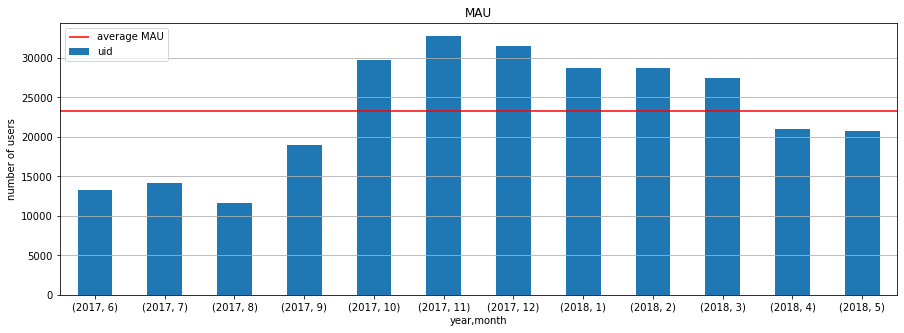

In [36]:
mau = visits.groupby(['year', 'month']).agg({'uid': 'nunique'})
mau.plot.bar(rot=0, figsize=(15, 5))
plt.hlines(mau_av, -1, 12, color='red', label= 'average MAU')
plt.legend(loc = 'upper left')
plt.title('MAU')
plt.ylabel('number of users')
plt.grid(axis='y')
plt.show()

MAU plot repeats trend observed on DAU and WAU plots. We can clearly see, that user activity declines from November 2017, decreasing by almost 1/3 by May 2018.The period of the most rapid growth lasted from August to November 2018.

#### Visits per day / user

In [37]:
visits_daily=visits.groupby('date').agg({'uid': ['count', 'nunique']}).reset_index()
visits_daily.columns = ['date', 'n_visits', 'n_users']
visits_daily['visits_per_user'] = (visits_daily['n_visits'] / visits_daily['n_users'])

visits_daily.head()

,date,n_visits,n_users,visits_per_user
0,2017-06-01,664,605,1.097521
1,2017-06-02,658,608,1.082237
2,2017-06-03,477,445,1.071910
3,2017-06-04,510,476,1.071429
4,2017-06-05,893,820,1.089024


In [38]:
visits_av = visits_daily['n_visits'].mean()
visits_per_user = (visits_daily['n_visits'].sum() / visits_daily['n_users'].sum())
print(F'\033[1mAverage number of visits per day: {round(visits_av)}\033[0m')
print(F'\033[1mNumber of visits to DAU: {round(visits_per_user,2)}\033[0m')

Average number of visits per day: 987
Number of visits to DAU: 1.09


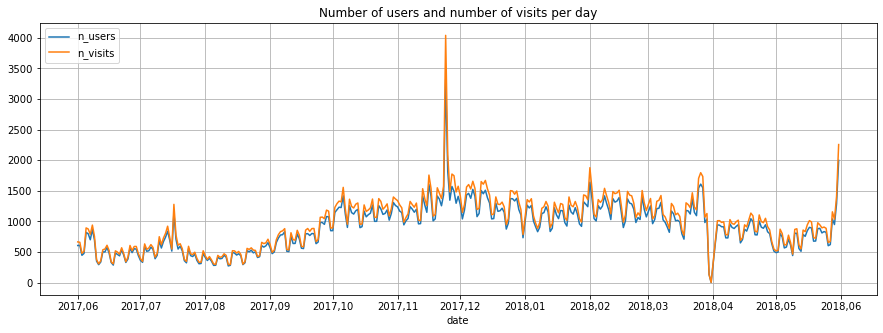

In [39]:
fig, axs = plt.subplots(figsize=(15, 5))
visits_daily.plot(kind='line', x="date", y="n_users", title='DAU', x_compat=True, grid='True', ax=axs)
visits_daily.plot(kind='line', x="date", y="n_visits", title='users', x_compat=True, grid='True', ax=axs)
plt.gca().xaxis.set_major_formatter(dtFmt) # apply the format to the desired axis
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1)) # show every 12th tick on x axes
plt.legend(loc = 'upper left')
plt.title('Number of users and number of visits per day')
plt.show(close='All')

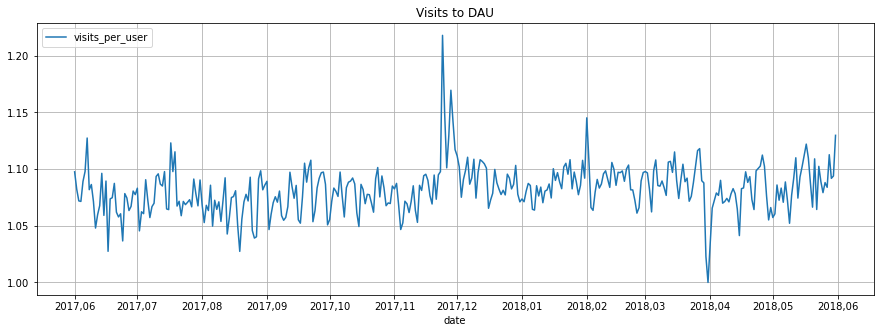

In [40]:
fig, axs = plt.subplots(figsize=(15, 5))
visits_daily.plot(kind='line', x="date", y="visits_per_user", title='visits to DAU', x_compat=True, grid='True', ax=axs)
plt.gca().xaxis.set_major_formatter(dtFmt) # apply the format to the desired axis
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1)) # show every 12th tick on x axes
plt.legend(loc = 'upper left')
plt.title('Visits to DAU')
plt.show(close='All')

Average user visits site once a day, small portion of users do it more often (visits to DAU ratio is 1.09). The dynamics of visits coincides with DAU plot.

#### ASL

Average session length, or ASL, is the amount of time users spend with a product in the average session.

In [41]:
visits['length'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
duration_av=round(visits['length'].mean(),2)
print(F'Average duration of visit in seconds (mean): {duration_av}')

Average duration of visit in seconds (mean): 643.51


In [42]:
visits['length'].describe()

count    359400.000000
mean        643.506489
std        1016.334786
min           0.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       84480.000000
Name: length, dtype: float64

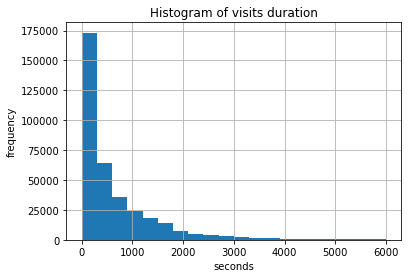

In [43]:
visits['length'].hist(bins=20,range=(0,6000))
plt.title('Histogram of visits duration')
plt.ylabel('frequency')
plt.xlabel('seconds')
plt.show()

The averge visit lenght is distorted by a large number of short visits

In [44]:
asl_mode=int(visits['length'].mode())
print(F'\033[1mASL mode: {asl_mode}\033[0m')
asl_mode_desktop=int(visits.query('device == "desktop"')['length'].mode())
print(F'ASL desktop mode: {asl_mode_desktop}')
asl_mode_touch=int(visits.query('device == "touch"')['length'].mode())
print(F'ASL touch mode: {asl_mode_touch}')

ASL mode: 60
ASL desktop mode: 60
ASL touch mode: 60


Most often the length of visit is about 60 seconds. It seems to be too short to buy a ticket, however it could be enough to check the schedule of events or read brief description of a certain event.

In [45]:
asl_median=int(visits['length'].median())
print(F'\033[1mASL median: {asl_median}\033[0m')
asl_median_desktop=int(visits.query('device == "desktop"')['length'].median())
print(F'ASL desktop median: {asl_median_desktop}')
asl_median_touch=int(visits.query('device == "touch"')['length'].median())
print(F'ASL touch median: {asl_median_touch}')

ASL median: 300
ASL desktop median: 360
ASL touch median: 180


Median length of visit via desktop device is twice longer than visit via touch device.

In [46]:
visit_length=visits.groupby('date').agg({'uid': 'count', 'length': 'mean'}).reset_index()
visit_length.columns = ['date', 'n_visits', 'asl']
visit_length.head()

,date,n_visits,asl
0,2017-06-01,664,666.320783
1,2017-06-02,658,619.840426
2,2017-06-03,477,606.958071
3,2017-06-04,510,554.309804
4,2017-06-05,893,624.450168


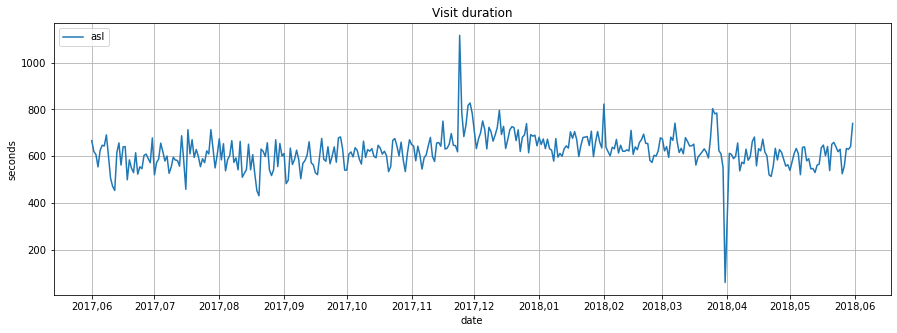

In [47]:
fig, axs = plt.subplots(figsize=(15, 5))
fig = visit_length.plot(kind='line', x="date", y="asl", title='Visit duration', grid='True', ax=axs, ylabel='seconds')
dtFmt = mdates.DateFormatter('%Y,%m') # define the formatting
plt.gca().xaxis.set_major_formatter(dtFmt) # apply the format to the desired axis
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1)) # show every 12th tick on x axes
plt.legend(loc = 'upper left')
plt.show(close='All')

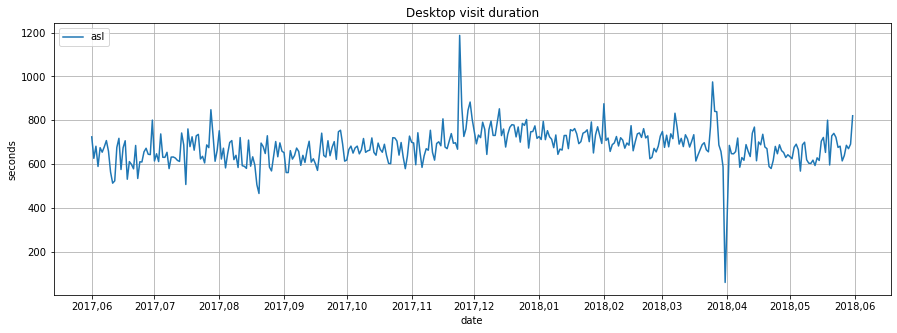

In [48]:
visits_desk=visits.query('device == "desktop"')
visit_length_desk=visits_desk.groupby('date').agg({'uid': 'count', 'length': 'mean'}).reset_index()
visit_length_desk.columns = ['date', 'n_visits', 'asl']
fig, axs = plt.subplots(figsize=(15, 5))
fig = visit_length_desk.plot(kind='line', x="date", y="asl", title='Desktop visit duration', grid='True', ax=axs, ylabel='seconds')
dtFmt = mdates.DateFormatter('%Y,%m') # define the formatting
plt.gca().xaxis.set_major_formatter(dtFmt) # apply the format to the desired axis
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1)) # show every 12th tick on x axes
plt.legend(loc = 'upper left')
plt.show(close='All')

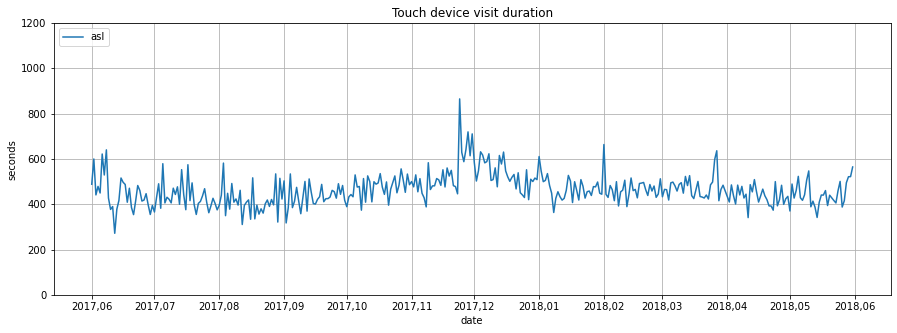

In [49]:
visits_touch=visits.query('device == "touch"')
visit_length_touch=visits_touch.groupby('date').agg({'uid': 'count', 'length': 'mean'}).reset_index()
visit_length_touch.columns = ['date', 'n_visits', 'asl']
fig, axs = plt.subplots(figsize=(15, 5))
fig = visit_length_touch.plot(kind='line', x="date", y="asl", title='Touch device visit duration', grid='True', ax=axs, ylabel='seconds')
plt.ylim((0,1200))
dtFmt = mdates.DateFormatter('%Y,%m') # define the formatting
plt.gca().xaxis.set_major_formatter(dtFmt) # apply the format to the desired axis
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1)) # show every 12th tick on x axes
plt.legend(loc = 'upper left')
plt.show(close='All')

The plots shows than drop in visits number / length in March 2018 has only affected desktop users. 

#### Retention rate per cohort

In [50]:
first_visit = visits.groupby(['uid'])['date'].min().reset_index()
first_visit.columns = ['uid', 'first_visit']
first_visit.head()

,uid,first_visit
0,11863502262781,2018-03-01
1,49537067089222,2018-02-06
2,297729379853735,2017-06-07
3,313578113262317,2017-09-18
4,325320750514679,2017-09-30


In [51]:
visits = visits.merge(first_visit, how='inner',on=['uid'])

In [52]:
visits['cohort']=visits['first_visit'].astype('datetime64[M]')
visits['age'] = ((visits['date'].astype('datetime64[M]') - visits['first_visit'].astype('datetime64[M]')) / np.timedelta64(1,'M')).round().astype('int')
visits.head()

,device,end_ts,source_id,start_ts,uid,year,month,week,date,length,first_visit,cohort,age
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,2017-12-14,2017-12-20,1080,2017-12-20,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,2018-02-15,2018-02-19,1680,2018-02-19,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,2017-06-29,2017-07-01,0,2017-07-01,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,2018-05-17,2018-05-20,1440,2018-03-09,2018-03-01,2
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018,3,2018-03-08,2018-03-09,1680,2018-03-09,2018-03-01,0


In [53]:
cohorts_visits = visits.pivot_table(index='cohort',
                  columns='age',
                  values='uid',
                  aggfunc='nunique')

In [54]:
cohorts_visits

age,0,1,2,3,4,5,6,7,8,9,10,11
cohort,,,,,,,,,,,,
2017-06-01,13259.0,1043.0,713.0,814.0,909.0,947.0,809.0,766.0,694.0,674.0,539.0,596.0
2017-07-01,13140.0,737.0,674.0,738.0,765.0,633.0,596.0,601.0,510.0,376.0,361.0,NaN
2017-08-01,10181.0,783.0,640.0,639.0,510.0,448.0,370.0,402.0,284.0,265.0,NaN,NaN
2017-09-01,16704.0,1428.0,1156.0,847.0,658.0,632.0,599.0,404.0,381.0,NaN,NaN,NaN
2017-10-01,25977.0,2042.0,1357.0,1012.0,890.0,837.0,555.0,529.0,NaN,NaN,NaN,NaN
2017-11-01,27248.0,2133.0,1202.0,1054.0,919.0,638.0,594.0,NaN,NaN,NaN,NaN,NaN
2017-12-01,25268.0,1410.0,960.0,786.0,512.0,481.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,22624.0,1351.0,890.0,565.0,458.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,22197.0,1267.0,565.0,446.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


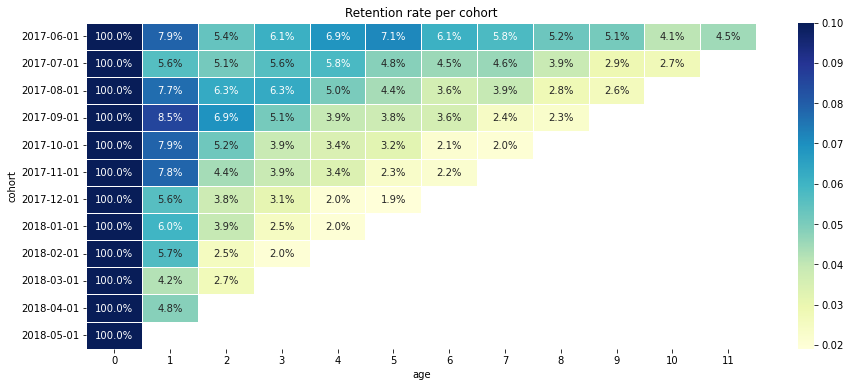

In [55]:
retention=cohorts_visits.iloc[:,0:].div(cohorts_visits[0], axis=0)
retention.index=retention.index.astype(str)

f, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(retention, annot=True, fmt='.1%', linewidths=1, linecolor='white', cmap="YlGnBu", vmax=0.1).set(title = 'Retention rate per cohort')
plt.show()

Retention rates tend to decrease for younger cohorts. For example we can look at 6 months retention: for June 2017 cohort it was 6.1%, and for November 2017 it was 2.2%. The marketing strategy should be revised. Analysis of marketing actions performed for older cohorts could improve current situation.

#### Retention rate per source

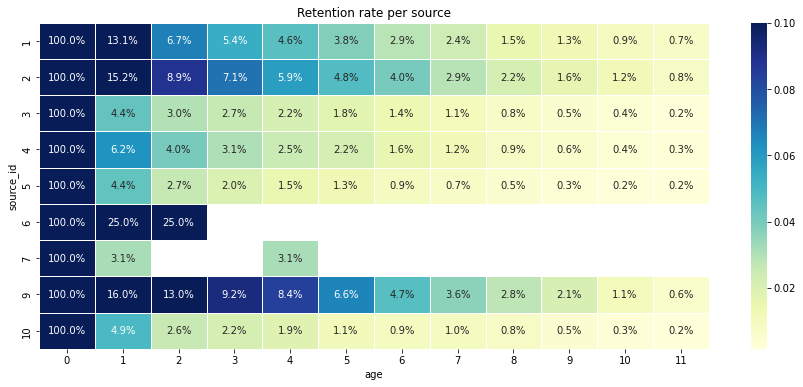

In [56]:
sources_visits = visits.pivot_table(index='source_id',
                  columns='age',
                  values='uid',
                  aggfunc='nunique')
sources_visits
retention_source =sources_visits.iloc[:,0:].div(sources_visits[0], axis=0)
retention_source.index=retention_source.index.astype(str)
retention_source
f, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(retention_source, annot=True, fmt='.1%', linewidths=1, linecolor='white', cmap="YlGnBu", vmax=0.1).set(title = 'Retention rate per source')
plt.show()

Retention rate varied significantly for different sources. Sources 1 and 2 had higher retention rates (13.1%-15.2% for month 1, 2.9%-4.0% for month 6) than sources 3-5 (4.4%-6.2% for month 1, 0.9%-1.6% for month 6). 

### Sales

#### Conversion

In [57]:
first_order = orders.groupby(['uid'])['buy_ts'].min().reset_index()
first_order.columns = ['uid', 'first_order']

In [58]:
visits=visits.merge(first_order, how='left',on=['uid'])


In [59]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 359400 entries, 0 to 359399
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   device       359400 non-null  object        
 1   end_ts       359400 non-null  datetime64[ns]
 2   source_id    359400 non-null  int64         
 3   start_ts     359400 non-null  datetime64[ns]
 4   uid          359400 non-null  uint64        
 5   year         359400 non-null  UInt32        
 6   month        359400 non-null  int64         
 7   week         359400 non-null  datetime64[ns]
 8   date         359400 non-null  object        
 9   length       359400 non-null  int64         
 10  first_visit  359400 non-null  object        
 11  cohort       359400 non-null  datetime64[ns]
 12  age          359400 non-null  int32         
 13  first_order  97394 non-null   datetime64[ns]
dtypes: UInt32(1), datetime64[ns](5), int32(1), int64(3), object(3), uint64(1)
memory usa

In [60]:
#creating dataset for users, who made orders 
customers=visits.dropna()
customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97394 entries, 3 to 359397
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   device       97394 non-null  object        
 1   end_ts       97394 non-null  datetime64[ns]
 2   source_id    97394 non-null  int64         
 3   start_ts     97394 non-null  datetime64[ns]
 4   uid          97394 non-null  uint64        
 5   year         97394 non-null  UInt32        
 6   month        97394 non-null  int64         
 7   week         97394 non-null  datetime64[ns]
 8   date         97394 non-null  object        
 9   length       97394 non-null  int64         
 10  first_visit  97394 non-null  object        
 11  cohort       97394 non-null  datetime64[ns]
 12  age          97394 non-null  int32         
 13  first_order  97394 non-null  datetime64[ns]
dtypes: UInt32(1), datetime64[ns](5), int32(1), int64(3), object(3), uint64(1)
memory usage: 10.5+ MB


In [61]:
pd.options.mode.chained_assignment = None  

In [62]:
#calculating conversion period in days
customers['conversion']=((pd.to_datetime(customers['first_order'])-pd.to_datetime(customers['first_visit']))/np.timedelta64(1,'D')).astype('int')
customers.head()

,device,end_ts,source_id,start_ts,uid,year,month,week,date,length,first_visit,cohort,age,first_order,conversion
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,2018-05-17,2018-05-20,1440,2018-03-09,2018-03-01,2,2018-03-09 20:25:00,0
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018,3,2018-03-08,2018-03-09,1680,2018-03-09,2018-03-01,0,2018-03-09 20:25:00,0
6,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017,9,2017-08-31,2017-09-03,60,2017-09-03,2017-09-01,0,2017-09-04 12:46:00,1
7,desktop,2017-10-27 16:02:00,3,2017-10-27 15:20:00,16007536194108375387,2017,10,2017-10-26,2017-10-27,2520,2017-09-03,2017-09-01,1,2017-09-04 12:46:00,1
8,desktop,2017-09-04 17:56:00,4,2017-09-04 17:37:00,16007536194108375387,2017,9,2017-08-31,2017-09-04,1140,2017-09-03,2017-09-01,0,2017-09-04 12:46:00,1


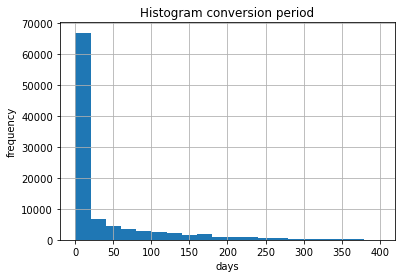

In [63]:
customers['conversion'].hist(bins=20,range=(0,400))
plt.title('Histogram conversion period')
plt.ylabel('frequency')
plt.xlabel('days')
plt.show()

Conversion period plot is skewed to the right, zero or small number of days prevail in the population.

In [64]:
customers['conversion'].describe()

count    97394.000000
mean        33.713750
std         63.348208
min          0.000000
25%          0.000000
50%          1.000000
75%         37.000000
max        363.000000
Name: conversion, dtype: float64

In [65]:
conversion_mode=int(customers['conversion'].mode())
conversion_mode

0

Most often visitor converts to customer at the date of first visit.

In [66]:
conversion_rate=customers['uid'].nunique()/visits['uid'].nunique()
print('\033[1mConversion rate: {:.1%}\033[0m'.format(conversion_rate))

Conversion rate: 16.0%


#### Conversion rate per source

In [67]:
first_source=visits.sort_values('start_ts').groupby('uid').first()['source_id'].reset_index()
first_source.columns=['uid','first_source']

In [68]:
orders=orders.merge(first_source,on=['uid'],how='left')

In [69]:
conversion_per_source=orders.groupby('first_source')['uid'].nunique().reset_index()
conversion_per_source.columns=['source_id', 'orders']

In [70]:
conversion_per_source=conversion_per_source.merge(visitors_per_source, how='left', on='source_id')
conversion_per_source.drop(columns = ['%'],axis = 1, inplace=True)
conversion_per_source['conv_rate, %']=round(conversion_per_source['orders']/conversion_per_source['uid']*100,2)
conversion_per_source

,source_id,orders,uid,"conv_rate, %"
0,1,2899,9469,30.62
1,2,3506,17616,19.90
2,3,10473,66116,15.84
3,4,10296,72346,14.23
4,5,6931,49237,14.08
5,7,1,32,3.12
6,9,1088,6448,16.87
7,10,1329,6903,19.25


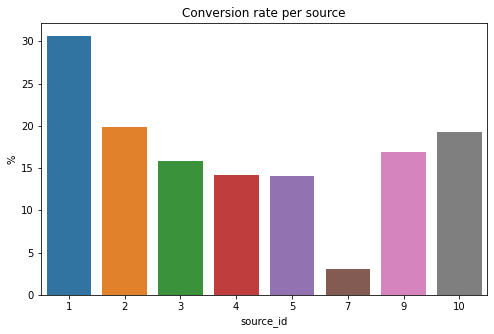

In [71]:
fig, axs = plt.subplots(figsize=(8, 5))
sns.barplot(data=conversion_per_source[['source_id', 'conv_rate, %']], x='source_id', y='conv_rate, %')
plt.title('Conversion rate per source')
plt.ylabel('%')
plt.show()

Conversion rate for source 1 (31%) if significantly higher than others (14%-20%).

#### Number of orders

In [72]:
total_orders=orders['uid'].count()
print(F'\033[1mNumber of orders: {total_orders}\033[0m')

Number of orders: 50415


In [73]:
orders_per_customer=round(orders['uid'].count()/orders['uid'].nunique(),2)
print(F'\033[1mNumber of orders per customer: {orders_per_customer}\033[0m')

Number of orders per customer: 1.38


In [74]:
orders['order_month']  = orders['buy_ts'].astype('datetime64[M]')

In [75]:
first_order['first_order']=first_order['first_order'].astype('datetime64[M]')
orders=orders.merge(first_order, how='left',on=['uid'])


In [76]:
cohort_orders = orders.groupby('first_order').agg({'uid': 'nunique'}).reset_index()
cohort_orders.columns=['first_order','cohort_size']


In [77]:
#calculating number of purchases for cohort and month
cohorts_customers=orders.groupby(['first_order','order_month'])['revenue'].count().reset_index()
cohorts_customers.columns=['first_order','order_month','orders']
#merge cohort with cohort size
cohorts_customers=cohorts_customers.merge(cohort_orders,on=['first_order'])
cohorts_customers['age_month'] = ((cohorts_customers['order_month'] - cohorts_customers['first_order']) / np.timedelta64(1,'M')).round().astype('int')
visits.head()
cohorts_customers['orders_per_customer']=cohorts_customers['orders']/cohorts_customers['cohort_size']


In [78]:
cohorts_customers_piv=cohorts_customers.pivot_table(
    index='first_order', 
    columns='age_month', 
    values='orders_per_customer', 
    aggfunc='sum').cumsum(axis=1)

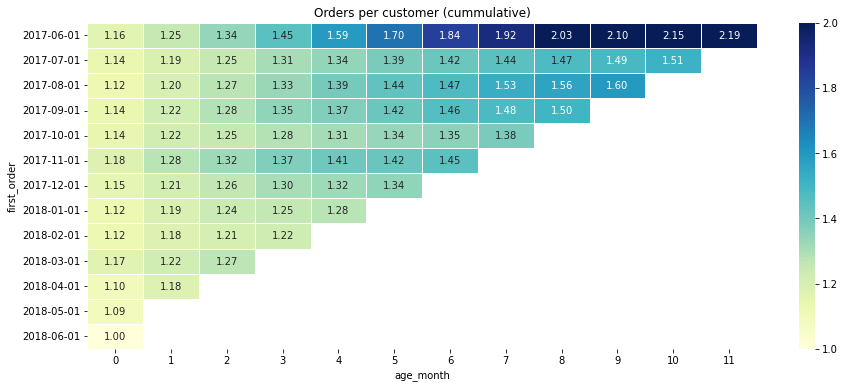

In [79]:
cohorts_customers_piv.index=cohorts_customers_piv.index.astype(str)
f, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(cohorts_customers_piv, annot=True, fmt='.2f', linewidths=1, linecolor='white', vmax=2, cmap="YlGnBu"
            ).set(title ='Orders per customer (cummulative)')
plt.show()

First cohort (June 2017) was far more affective in terms of repetitive orders (1.84 orders per customer over 6 month as compared to 1.35-1.47 for others cohorts).

#### Revenue per order

In [80]:
total_revenue=round(orders['revenue'].sum())
print(F'\033[1mTotal revenue: {total_revenue}\033[0m')

Total revenue: 252057


In [81]:
orders['revenue'].describe()

count    50415.000000
mean         4.999647
std         21.818359
min          0.000000
25%          1.220000
50%          2.500000
75%          4.890000
max       2633.280000
Name: revenue, dtype: float64

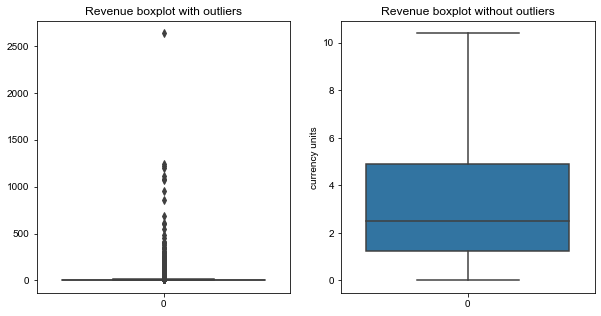

In [82]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.boxplot(data=orders['revenue'], showfliers=True, ax=axes[0]).set(title='Revenue boxplot with outliers')
sns.boxplot(data=orders['revenue'], showfliers=False, ax=axes[1]).set(title='Revenue boxplot without outliers')
sns.set_style("whitegrid")
plt.ylabel('currency units')
plt.show()

In [83]:
orders.query('revenue == 0')['uid'].count()

51

In [84]:
Q1 = orders['revenue'].quantile(0.25)
Q3 = orders['revenue'].quantile(0.75)
IQR = Q3 - Q1
max_iqr=Q3+1.5*IQR
print(F'Maximum border to determine outliers: {max_iqr}')

Maximum border to determine outliers: 10.395


In [85]:
print('Total number of outlier orders: {}'.format(orders.query('revenue > 10.395')['uid'].count()))
print('Total revenue for outlier orders: {}'.format(orders.query('revenue > 10.395')['revenue'].sum()))
print('Share of outlier orders revenue in total revenue: {:.1%}'.format(orders.query('revenue > 10.395')['revenue'].sum()
                                                                   /total_revenue))

Total number of outlier orders: 3990
Total revenue for outlier orders: 111986.97
Share of outlier orders revenue in total revenue: 44.4%


In [86]:
orders['order_date']=orders['buy_ts'].dt.date

In [87]:
orders_av=orders.groupby('order_date')['revenue'].mean().reset_index()


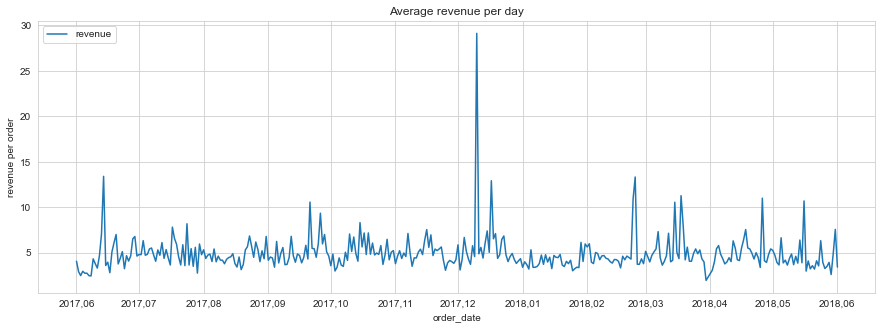

In [88]:
fig, axs = plt.subplots(figsize=(15, 5))
fig = orders_av.plot(kind='line', x="order_date", y="revenue", title='Average revenue per day', x_compat=True, grid='True', ax=axs, ylabel='revenue per order')
dtFmt = mdates.DateFormatter('%Y,%m') # define the formatting
plt.gca().xaxis.set_major_formatter(dtFmt) # apply the format to the desired axis
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1)) # show every 12th tick on x axes
plt.legend(loc = 'upper left')
plt.show(close='All')

In [89]:
revenue_per_order=round(orders['revenue'].mean(),2)
print(F'\033[1mRevenue per order: {revenue_per_order}\033[0m')

Revenue per order: 5.0


Average revenue per order is about 5 currency units, however, there are a number of outliers (large orders) with maximum revenue per order of 2633 currency units. Orders with amount above statistically significant sample maximum of 10.395 currency units comprise 44% of total revenue, i.e. make a very significant input to all revenue trends.

#### Revenue per order per cohort

In [90]:
cohorts_revenue=orders.groupby(['first_order','order_month'])['revenue'].mean().reset_index()
cohorts_revenue['age_month'] = ((cohorts_revenue['order_month'] - cohorts_revenue['first_order']) / np.timedelta64(1,'M')).round().astype(int)
cohorts_revenue.head()

,first_order,order_month,revenue,age_month
0,2017-06-01,2017-06-01,4.060106,0
1,2017-06-01,2017-07-01,5.547006,1
2,2017-06-01,2017-08-01,5.088161,2
3,2017-06-01,2017-09-01,8.545575,3
4,2017-06-01,2017-10-01,7.084178,4


In [91]:
cohorts_revenue_piv=cohorts_revenue.pivot_table(
    index='first_order', 
    columns='age_month', 
    values='revenue', 
    aggfunc='mean')

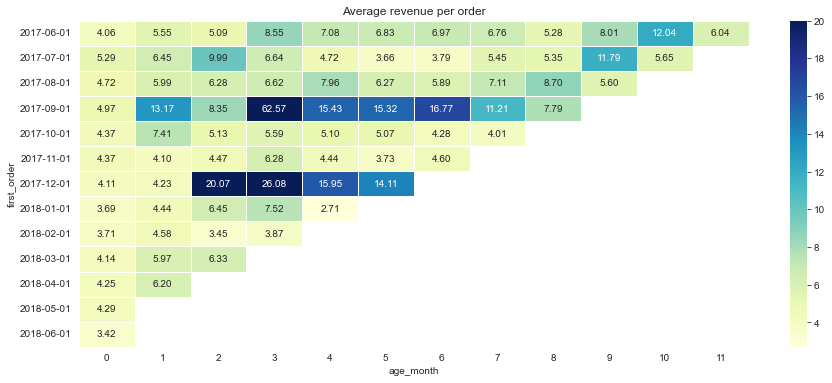

In [92]:
cohorts_revenue_piv.index=cohorts_revenue_piv.index.astype(str)
f, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(cohorts_revenue_piv, annot=True, fmt='.2f', linewidths=1, linecolor='white', vmax=20, cmap="YlGnBu"
            ).set(title ='Average revenue per order')
plt.show()

Distribution of revenue between cohorts is uneven. There are cohorts with average revenue per order fluctuating about 5 currency units and there are cohorts with average revenue in some months going up to 26 currency units (December 2017 cohort) and 63 currency units (September 2017 cohort).

#### LTV per cohort

LTV (lifetime value) is the total amount of money the average customer brings to the company by making purchases. 
We do not have data on margin %, so we assume revenue amount in `orders` is already net of any variable expenses.

In [93]:
#get the revenue per cohort in each month
cohorts_ltv=orders.groupby(['first_order','order_month'])['revenue'].sum().reset_index()
cohorts_ltv.columns = ['first_order','order_month','revenue']
#merge with the cohort size
cohorts_ltv=cohorts_ltv.merge(cohort_orders,on=['first_order'])
cohorts_ltv['age']=((cohorts_ltv['order_month'] - cohorts_ltv['first_order']) / np.timedelta64(1,'M')).round()
cohorts_ltv['ltv']=cohorts_ltv['revenue']/cohorts_ltv['cohort_size']

In [94]:
cohorts_ltv

,first_order,order_month,revenue,cohort_size,age,ltv
0,2017-06-01,2017-06-01,9557.49,2023,0.0,4.724414
1,2017-06-01,2017-07-01,981.82,2023,1.0,0.485329
2,2017-06-01,2017-08-01,885.34,2023,2.0,0.437637
3,2017-06-01,2017-09-01,1931.30,2023,3.0,0.954671
4,2017-06-01,2017-10-01,2068.58,2023,4.0,1.022531
...,...,...,...,...,...,...
74,2018-03-01,2018-05-01,1114.87,3533,2.0,0.315559
75,2018-04-01,2018-04-01,10600.69,2276,0.0,4.657597
76,2018-04-01,2018-05-01,1209.92,2276,1.0,0.531599
77,2018-05-01,2018-05-01,13925.76,2988,0.0,4.660562


In [95]:
cohorts_ltv_piv=cohorts_ltv.pivot_table(
    index='first_order', 
    columns='age', 
    values='ltv', 
    aggfunc='sum').cumsum(axis=1)

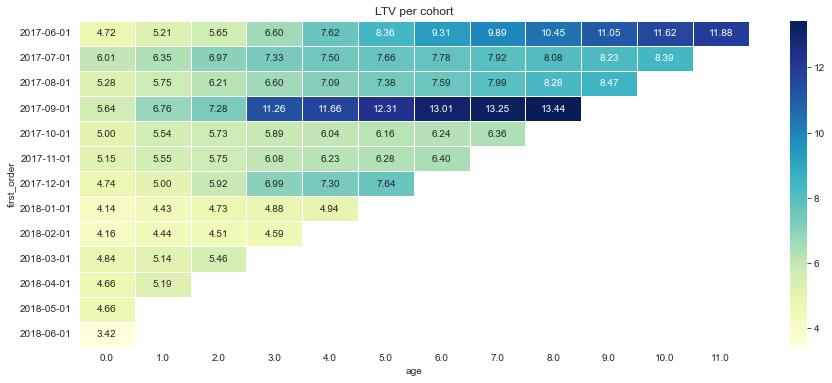

In [96]:
cohorts_ltv_piv.index=cohorts_ltv_piv.index.astype(str)
f, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(cohorts_ltv_piv, annot=True, fmt='.2f', linewidths=1, linecolor='white', cmap="YlGnBu"
            ).set(title ='LTV per cohort')
plt.show()

LTV matrix draws attention to cohort June 2017 where high LTV is steadily supported by good retention rates and repetitive orders.
The rest cohorts are demonstrating the overall slowdown in growth rate with every next cohort, which is however distorted by orders-outliers made by September 2017 and December 2017 cohorts.

In [97]:
revenue_per_customer=round(total_revenue/customers['uid'].nunique(),2)
print(F'\033[1mRevenue per customer: {revenue_per_customer}\033[0m')

Revenue per customer: 6.9


### Marketing

#### Costs per source

In [98]:
total_costs=round(costs['costs'].sum())
print(F'\033[1mTotal costs: {total_costs}\033[0m')

Total costs: 329132


In [99]:
costs_per_source=costs.groupby('source_id')['costs'].sum().reset_index()
costs_per_source

,source_id,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


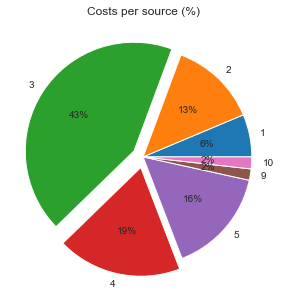

In [100]:
fig, ax = plt.subplots(figsize=(5,5))
explode = (0, 0, 0.1, 0.1, 0, 0, 0)
ax.pie(costs_per_source['costs'], explode=explode, labels = costs_per_source['source_id'], autopct='%.0f%%')
ax.set_title('Costs per source (%)')
plt.show()

In [101]:
costs['month']=costs['dt'].astype('datetime64[M]')

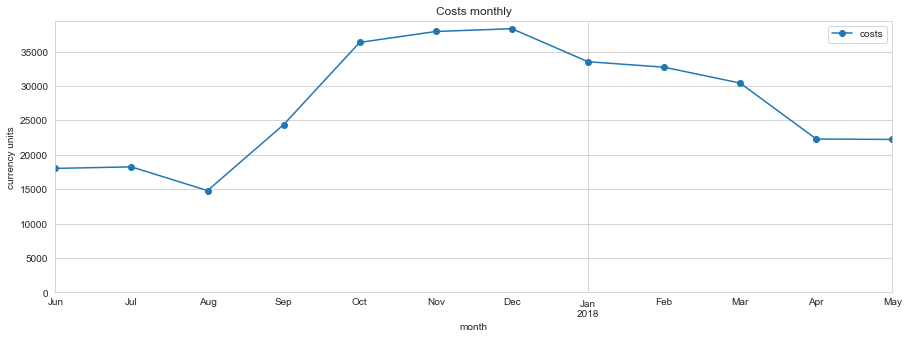

In [102]:
costs_monthly_total=costs.pivot_table(index='month',values='costs', aggfunc='sum')
fig, axs = plt.subplots(figsize=(15, 5))
costs_monthly_total.plot.line(rot=0, ax=axs, title='Costs monthly', ylabel='currency units', xlabel='month', marker="o")
plt.ylim(0)
plt.show()

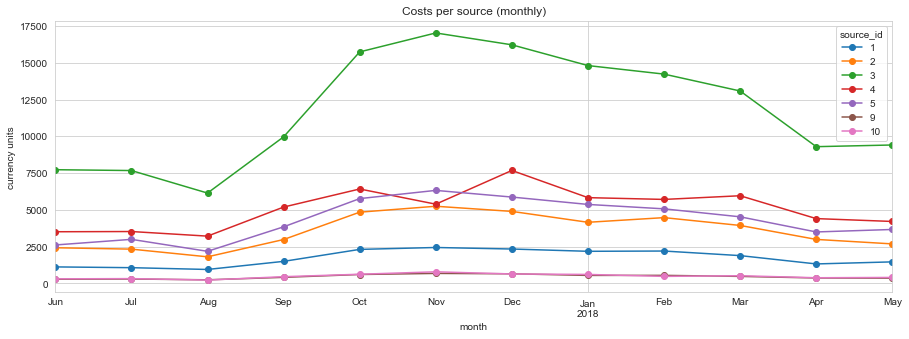

In [103]:
costs_monthly=costs.pivot_table(index='month',columns='source_id',values='costs', aggfunc='sum')
fig, axs = plt.subplots(figsize=(15, 5))
costs_monthly.plot.line(rot=0, ax=axs, title='Costs per source (monthly)', ylabel='currency units', xlabel='month', marker="o")
plt.show()

Source 3 is leading in total marketing costs (42% of total). Fluctuations of costs per month are shown in the plot above.

#### CAC

CAC (customer acquisition cost) is the cost of attracting a customer.

We calculate CAC by month. We divide marketing expenses for a given month by number of customers in this month's cohort (that was calculated previously and stored at `cohort_orders`).

In [104]:
cohort_orders.head()

,first_order,cohort_size
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340


In [105]:
costs_per_month=costs.groupby('month')['costs'].sum().reset_index()
revenue_per_month=orders.groupby('order_month')['revenue'].sum().reset_index()
revenue_per_month.columns=['month','revenue']
marketing=revenue_per_month.merge(costs_per_month, on='month')
marketing

,month,revenue,costs
0,2017-06-01,9557.49,18015.00
1,2017-07-01,12539.47,18240.59
2,2017-08-01,8758.78,14790.54
3,2017-09-01,18345.51,24368.91
4,2017-10-01,27987.70,36322.88
5,2017-11-01,27069.93,37907.88
6,2017-12-01,36388.60,38315.35
7,2018-01-01,19417.13,33518.52
8,2018-02-01,25560.54,32723.03
9,2018-03-01,28834.59,30415.27


In [106]:
cohort_orders.columns=['month', 'customers']
marketing=marketing.merge(cohort_orders, on='month')
marketing['cac']=marketing['costs']/marketing['customers']

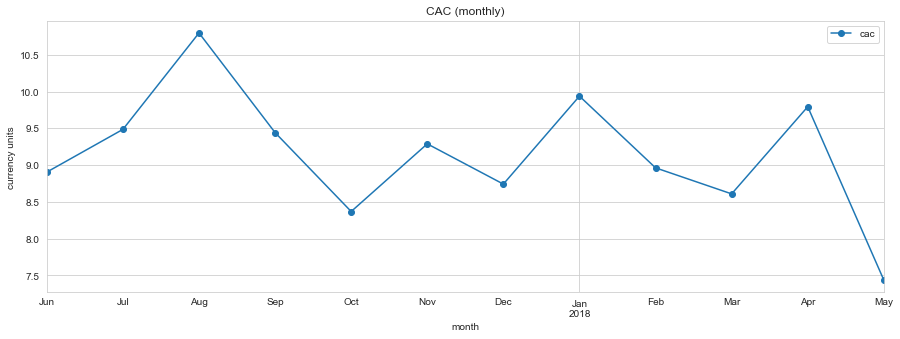

In [107]:
fig, axs = plt.subplots(figsize=(15, 5))
marketing[['cac', 'month']].plot(rot=0, x='month',
        kind='line',
        title='CAC (monthly)', ax=axs, ylabel='currency units', marker="o")
plt.show()

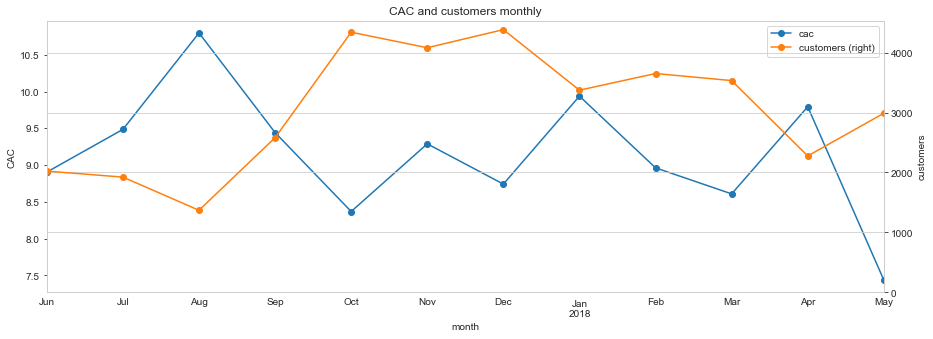

In [108]:
fig, axs = plt.subplots(figsize=(15, 5))

ax = marketing[['cac', 'month']].plot(rot=0, x='month',
        kind='line',
        ax=axs, marker="o")
ax2 = marketing[['customers', 'month']].plot(rot=0, x='month',
        kind='line',
        ax=axs, marker="o", secondary_y = True)

ax.set_xlabel('month')
ax.set_ylabel('CAC')
ax2.set_ylabel('customers')

plt.title('CAC and customers monthly')
plt.ylim(0)
plt.show()

As we can see in the plot above, CAC is more affected by fluctuations in number of customers, that was not always in line with marketing expenses incurred. For example, despite the increase in marketing costs in November 2017, the number of customers decreased causing the increase of CAC.

In [109]:
cac_av=round(total_costs/customers['uid'].nunique(),2)
print(F'\033[1mAverage CAC: {cac_av}\033[0m')

Average CAC: 9.01


#### CAC per source

In [110]:
orders_source=orders.groupby(['first_source'])['uid'].nunique().reset_index()
orders_source.columns=['source','customers']

In [111]:
marketing_source=costs.groupby('source_id')['costs'].sum().reset_index()
marketing_source.columns=['source','costs']

In [112]:
cac_source=marketing_source.merge(orders_source, how='left', on=['source'])
cac_source['cac']=cac_source['costs']/cac_source['customers']
cac_source

,source,costs,customers,cac
0,1,20833.27,2899,7.186364
1,2,42806.04,3506,12.209367
2,3,141321.63,10473,13.493901
3,4,61073.60,10296,5.931779
4,5,51757.10,6931,7.467479
5,9,5517.49,1088,5.071222
6,10,5822.49,1329,4.381106


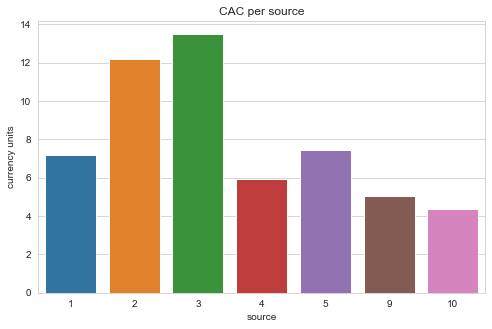

In [113]:
fig, axs = plt.subplots(figsize=(8, 5))
sns.barplot(data=cac_source[['source','cac']], x='source', y='cac')
plt.title('CAC per source')
plt.ylabel('currency units')
plt.show()

Source 3 (most significant in marketing costs) has the highest CAC (13.49 currency units), followed by source 2 (12.21). CAC for the rest sources varies from 4.38 to 7.47 currency units for 1 customer.

In [114]:
orders_month_source=orders.groupby(['first_order','first_source'])['uid'].nunique().reset_index()
orders_month_source.columns=['month','source','customers']

In [115]:
marketing_month_source=costs.groupby(['month','source_id'])['costs'].sum().reset_index()
marketing_month_source.columns=['month','source','costs']

In [116]:
cac_month_source=marketing_month_source.merge(orders_month_source, how='left', on=['month','source'])
cac_month_source['cac']=cac_month_source['costs']/cac_month_source['customers']

In [117]:
cac_month_source_piv=cac_month_source.pivot_table(index='month',columns='source',values='cac')

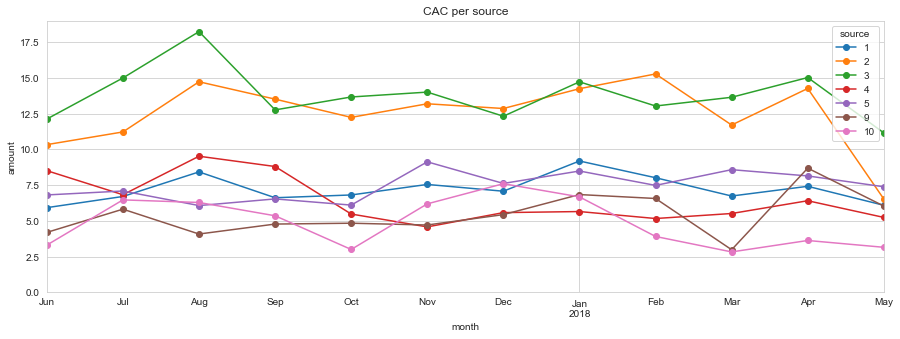

In [118]:
fig, axs = plt.subplots(figsize=(15, 5))
cac_month_source_piv.plot.line(ax=axs, title='CAC per source', ylabel='amount',marker='o')
plt.ylim(0)
plt.show()

CAC monthly fluctuations for different sources could be significant, which should be taken into account in planning of marketing expenses. 

#### ROMI

ROMI is return in marketing investments

In [119]:
print('Total revenue: {}'.format(total_revenue))
print('Total costs: {}'.format(total_costs))
print('Net result: {}'.format(total_revenue - total_costs))

Total revenue: 252057
Total costs: 329132
Net result: -77075


In [120]:
romi_av=round(revenue_per_customer/cac_av,2)
print('\033[1mAverage ROMI: {}\033[0m'.format(romi_av))

Average ROMI: 0.77


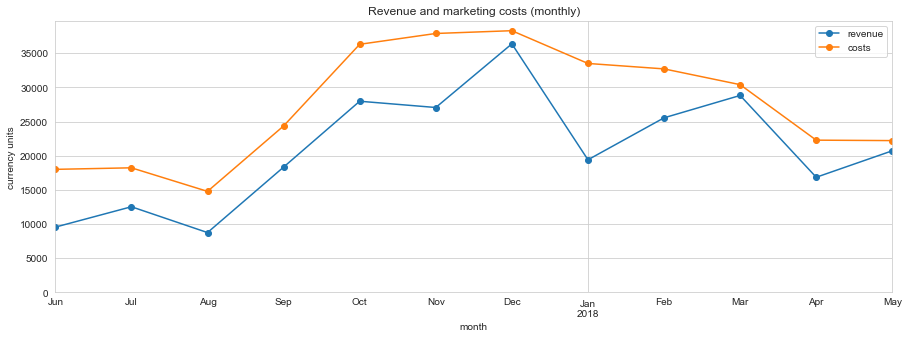

In [121]:
fig, axs = plt.subplots(figsize=(15, 5))
marketing[['month','revenue','costs']].plot(rot=0, x='month',
        kind='line',        
        title='Revenue and marketing costs (monthly)', ax=axs, ylabel='currency units', marker="o")
plt.ylim(0)
plt.show()

Until October 2017 trends in monthly revenue and marketing costs coincides, though revenue never exceeds costs. Starting form November 2017 dynamics become different, with sudden drops in revenue in some months, which do not accompanied by the respective decrease in costs.

#### ROMI per cohort

In [122]:
cac_source_romi=marketing[['month','cac']]
cac_source_romi.columns=['first_order','cac']
romi=cohorts_ltv.merge(cac_source_romi,on=['first_order'],how='left')
romi.head()

,first_order,order_month,revenue,cohort_size,age,ltv,cac
0,2017-06-01,2017-06-01,9557.49,2023,0.0,4.724414,8.905091
1,2017-06-01,2017-07-01,981.82,2023,1.0,0.485329,8.905091
2,2017-06-01,2017-08-01,885.34,2023,2.0,0.437637,8.905091
3,2017-06-01,2017-09-01,1931.30,2023,3.0,0.954671,8.905091
4,2017-06-01,2017-10-01,2068.58,2023,4.0,1.022531,8.905091


In [123]:
romi['romi']=romi['ltv']/romi['cac']
romi_piv = romi.pivot_table(
    index='first_order', columns='age', values='romi', aggfunc='mean'
).cumsum(axis=1).round(2) 

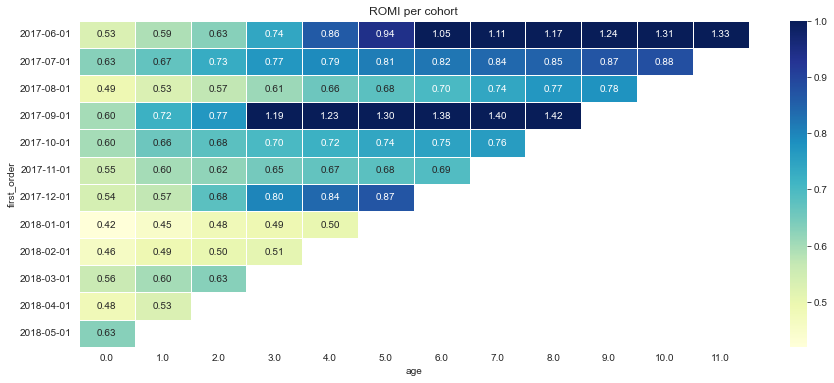

In [124]:
romi_piv.index=romi_piv.index.astype(str)
f, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(romi_piv, annot=True, fmt='.2f', linewidths=1, vmax=1, linecolor='white', cmap="YlGnBu").set(title ='ROMI per cohort')
plt.show()

Marketing costs paid off only for 2 cohorts: June 2017 on the 6th month and September 2017 on 3d month. January 2018 and February 2018 cohorts appears to be the slowest in terms of pay-off with only half of expenses compensated by revenue on 3d month.

#### ROMI per source

In [125]:
orders.head()

,buy_ts,revenue,uid,first_source,order_month,first_order,order_date
0,2017-06-01 00:10:00,17.00,10329302124590727494,1,2017-06-01,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2,2017-06-01,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2,2017-06-01,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2,2017-06-01,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,3,2017-06-01,2017-06-01,2017-06-01


In [126]:
ltv_per_source=orders.groupby(['first_source'])[['uid','revenue']].agg({'uid':'nunique','revenue':'sum'}).reset_index()
ltv_per_source.columns=['source_id','customers','revenue']
ltv_per_source['ltv']=ltv_per_source['revenue']/ltv_per_source['customers']

In [127]:
romi_per_source=costs_per_source.merge(ltv_per_source,on=['source_id'])
romi_per_source['cac']=romi_per_source['costs']/romi_per_source['customers']
romi_per_source['romi']=romi_per_source['ltv']/romi_per_source['cac']
romi_per_source

,source_id,costs,customers,revenue,ltv,cac,romi
0,1,20833.27,2899,31090.55,10.724577,7.186364,1.492351
1,2,42806.04,3506,46923.61,13.383802,12.209367,1.096191
2,3,141321.63,10473,54511.24,5.204931,13.493901,0.385725
3,4,61073.60,10296,56696.83,5.506685,5.931779,0.928336
4,5,51757.10,6931,52624.02,7.592558,7.467479,1.016750
5,9,5517.49,1088,5759.40,5.293566,5.071222,1.043844
6,10,5822.49,1329,4450.33,3.348631,4.381106,0.764335


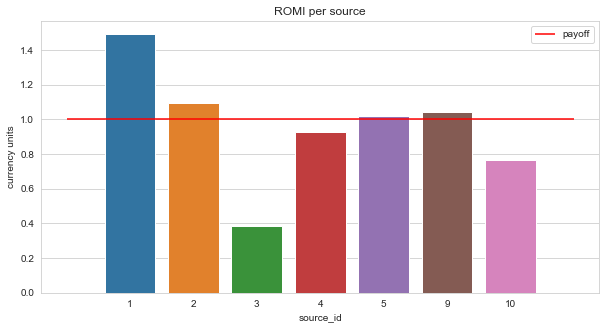

In [128]:
fig, axs = plt.subplots(figsize=(10, 5))
sns.barplot(data=romi_per_source[['source_id', 'romi']], x='source_id', y='romi')
plt.title('ROMI per source')
plt.ylabel('currency units')
plt.hlines(1, -1, 7, color='red', label='payoff')
plt.legend()
plt.show()

In terms of ROMI source 1 is most attractive (1.49), sources 2 and 9 are slightly above payoff line and the rest sources did not pay off. Source 3 has the lowest ROMI of 0.39.

## Conclusion: advise to marketing experts

### Metrics summary

In [129]:
print('\033[1mFunnel metrics:\033[0m')
print(F'Number of visits: {total_visits}')
print(F'Number of visitors: {total_visitors}')
print(F'Conversion period (days): {conversion_mode}')
print('Conversion rate: {:.1%}'.format(conversion_rate))
print('Number of customers: {}'.format(customers['uid'].nunique()))
print(F'Number of orders: {total_orders}')

Funnel metrics:
Number of visits: 359400
Number of visitors: 228169
Conversion period (days): 0
Conversion rate: 16.0%
Number of customers: 36523
Number of orders: 50415


In [130]:
print('\033[1mUser metrics:\033[0m')
print(F'Average DAU: {dau_av}')
print(F'Average WAU: {wau_av}')
print(F'Average MAU: {mau_av}')
print(F'Number of visits to DAU: {round(visits_per_user,2)}')
print(F'ASL mode (seconds): {asl_mode}')

User metrics:
Average DAU: 907
Average WAU: 5724
Average MAU: 23228
Number of visits to DAU: 1.09
ASL mode (seconds): 60


In [131]:
print('\033[1mUnit economics metrics::\033[0m')
print(F'Revenue per order: {revenue_per_order}')
print(F'Number of orders per customer: {orders_per_customer}')
print(F'Revenue per customer: {revenue_per_customer}')
print(F'Average CAC: {cac_av}')
print('Average ROMI: {}'.format(romi_av))

Unit economics metrics::
Revenue per order: 5.0
Number of orders per customer: 1.38
Revenue per customer: 6.9
Average CAC: 9.01
Average ROMI: 0.77


### Summary on cohort analysis

- Retention rates tend to decrease for younger cohorts. For example we can look at 6 months retention: for June 2017 cohort it was 6.1%, and for November 2017 it was 2.2%. 
- First cohort (June 2017) was far more affective in terms of repetitive orders (1.84 orders per customer over 6 month as compared to 1.35-1.47 for others cohorts).
- Distribution of revenue between cohorts is uneven. There are cohorts with average revenue per order fluctuating about 5 currency units and there are cohorts with average revenue in some months going up to 26 currency units (December 2017 cohort) and 63 currency units (September 2017 cohort).
- LTV matrix draws attention to cohort June 2017 where high LTV is steadily supported by good retention rates and repetitive orders.The rest cohorts are demonstrating the overall slowdown in growth rate with every next cohort, which is however distorted by orders-outliers made in September 2017 and December 2017 cohorts.
- Marketing costs paid off only for 2 cohorts: June 2017 on the 6th month and September 2017 on 3d month. January 2018 and February 2018 cohorts appears to be the slowest in terms of pay-off with only half of expenses compensated by revenue on 3d month.

**Overall conclusions on cohort analysis:**
- June 2017 cohort could be used a benchmark for future actions, as it has demonstrated best results in all aspects of analysis.
- Performance results for 2 cohorts (September 2017 and December 2017) were significantly positively affected by outliers - atypically large amounts of revenue per order. These orders could be investigated in more details to update marketing strategy accordingly.

### Summary on ad sources analysis

In [132]:
romi_per_source=romi_per_source.merge(conversion_per_source[['source_id','conv_rate, %']], on='source_id')

In [133]:
romi_per_source['revenue_%']=round(romi_per_source['revenue']/ total_revenue*100,2)
romi_per_source['customers_%']=round(romi_per_source['customers']/ orders['uid'].nunique()*100,2)
romi_per_source['costs_%']=round(romi_per_source['costs']/ total_costs*100,2)
romi_per_source['net_result']=romi_per_source['revenue']-romi_per_source['costs']
romi_per_source=romi_per_source[[
    'source_id', 'costs', 'costs_%', 'conv_rate, %', 'customers', 
    'customers_%', 'revenue', 'revenue_%','cac', 'ltv','romi','net_result']]
romi_per_source

,source_id,costs,costs_%,"conv_rate, %",customers,customers_%,revenue,revenue_%,cac,ltv,romi,net_result
0,1,20833.27,6.33,30.62,2899,7.94,31090.55,12.33,7.186364,10.724577,1.492351,10257.28
1,2,42806.04,13.01,19.90,3506,9.60,46923.61,18.62,12.209367,13.383802,1.096191,4117.57
2,3,141321.63,42.94,15.84,10473,28.68,54511.24,21.63,13.493901,5.204931,0.385725,-86810.39
3,4,61073.60,18.56,14.23,10296,28.19,56696.83,22.49,5.931779,5.506685,0.928336,-4376.77
4,5,51757.10,15.73,14.08,6931,18.98,52624.02,20.88,7.467479,7.592558,1.016750,866.92
5,9,5517.49,1.68,16.87,1088,2.98,5759.40,2.28,5.071222,5.293566,1.043844,241.91
6,10,5822.49,1.77,19.25,1329,3.64,4450.33,1.77,4.381106,3.348631,0.764335,-1372.16


**Overall conclusion on ad sources analysis:**
- Source 3, that is leading in total marketing costs with 42% share in total, has the lowest ROMI of 0.39. It has generated 86 thousand of losses in the considered period. Obviously funds should be reallocated to other sources.
- Source 1 appears to be the most attractive: with ROMI of 1.49 and conversion rate of 30% (as compared to 16% of source 3) it has perspectives to bring much more customers and revenue, if funds are reallocated to it from source 3.
- Sources 2 and 9 could be considered as additional sources of traffic, if source 1 has limitations on usage. Both have ROMI slightly above 1 and conversion rates above current overall conversion rate.
- Source 5 generates significant part of total revenue (21%, 52 thousands), which is almost totally eliminated by expenses: net result is less than 1 thousand. I recommend analyze side benefits of this source, and if there none - consider stop using this source.
- Sources 4 and 10 has negative ROMI and generates net losses, therefore, again, if no significant side benefits or other considerations - funds should allocated to more promising sources.  